In [1]:
## load necessary modules
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from utils.tools import *
from utils.losses import *
from models.mnist import *

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [2]:
## hyper-parameters
random_seed = 2020
critic_iter = 10
critic_iter_d = 10
epochs = 40
std = 0.5
learning_rate = 5e-4
weight_decay = 0.01
batch_size = 250
nc = 1
z_dim = 5
# d_dim = 512
# g_dim = 512
lambda_mmd = 10.0
lambda_gp = 0.1
# lambda_power = 1.0

In [3]:
## Training
# torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # check if gpu is available

## initialize models
netI = I_MNIST(num_classes=z_dim)
netG = G_MNIST(nz=z_dim)
netD = D_MNIST(nz=z_dim, power = 5)
netI = netI.to(device)
netG = netG.to(device)
netD = netD.to(device)
netI = nn.DataParallel(netI)
netG = nn.DataParallel(netG)
netD = nn.DataParallel(netD)

## set up optimizers
optim_I = optim.Adam(netI.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_G = optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=learning_rate * 5, betas=(0.5, 0.999), 
                     weight_decay=weight_decay)

## load datasets
# train_gen, dev_gen, test_gen = load(batch_size, batch_size)
# data = inf_train_gen_mnist(train_gen)
transform    = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_gen    = dsets.MNIST(root="./datasets",train=True, transform=transform, download=True)
test_gen     = dsets.MNIST(root="./datasets",train=False, transform=transform, download=True)
train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_gen, batch_size=batch_size, shuffle=True)


## initial empty lists for training progress
primal_loss_GI = []
dual_loss_GI = []
# primal_loss = []
# dual_loss = []
# primal_loss_z = []
loss_mmd = []
gp = []
re = []

In [4]:
# import numpy as np
# import pingouin as pg

# np.random.seed(123)
# mean, cov, n = [4, 5], [(1, .6), (.6, 1)], 30
# x, y = np.random.multivariate_normal(mean, cov, n).T

# # T-test
# pg.ttest(x, y)

In [5]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate pandas2ri
pandas2ri.activate()

# Create a Torch tensor
# tensor = torch.randn(100, 3)

# Convert the tensor to a Pandas DataFrame
# df = pd.DataFrame(tensor.numpy())

# Load MVN in R
robjects.r('''
   library(MVN)
''')

# Define a function to run MVN in R
run_mvn = robjects.r('''
   function(df){
       result <- mvn(df)
       return(list(result$multivariateNormality, result$univariateNormality))
   }
''')

# Run MVN test
# mvn_result = run_mvn(df)
# print(mvn_result)


In [6]:
# ************************
# *** iWGANs Algorithm ***
# ************************
z_sample = torch.randn(batch_size, z_dim)
z_sample = z_sample.to(device)

for epoch in range(epochs):
    data = iter(train_loader)
    # 1. Update G, I network
    # (1). Set up parameters of G, I to update
    #      set up parameters of D to freeze
    for p in netD.parameters():
        p.requires_grad = False
    for p in netI.parameters():
        p.requires_grad = True
    for p in netG.parameters():
        p.requires_grad = True
    # (2). Update G and I
    for _ in range(critic_iter):
        images, _ = next(data)
        x = images.view(batch_size, 784).to(device)
        z = torch.randn(batch_size, z_dim).to(device)
        fake_z = netI(x)
        fake_x = netG(z)
        netI.zero_grad()
        netG.zero_grad()
        cost_GI = GI_loss(netI, netG, netD, z, fake_z)
        images, _ = next(data)
        x = images.view(batch_size, 784).to(device)
        z = torch.randn(batch_size, z_dim).to(device)
        fake_z = netI(x)
        mmd = mmd_penalty(fake_z, z, kernel="IMQ")
        primal_cost = cost_GI + lambda_mmd * mmd
        primal_cost.backward()
        optim_I.step()
        optim_G.step()
#     print('GI: '+str(primal(netI, netG, netD, real_data).cpu().item()))
    print('GI: '+str(cost_GI.cpu().item()))
    # (3). Append primal and dual loss to list
    primal_loss_GI.append(primal(netI, netG, netD, z).cpu().item())
    dual_loss_GI.append(dual(netI, netG, netD, z, fake_z).cpu().item())
    # 2. Update D network
    # (1). Set up parameters of D to update
    #      set up parameters of G, I to freeze
    for p in netD.parameters():
        p.requires_grad = True
    for p in netI.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False
    # (2). Update D
    for _ in range(critic_iter_d):
        images, y = next(data)
        x = images.view(batch_size, 784).to(device)
        z = torch.randn(batch_size, z_dim).to(device)
        fake_z = netI(x)
        fake_x = netG(z)
        netD.zero_grad()
        cost_D = D_loss(netI, netG, netD, z, fake_z)
        images, y = next(data)
        x = images.view(batch_size, 784)
        x = x.to(device)
        z = torch.randn(batch_size, z_dim)
        z = z.to(device)
        fake_z = netI(x)
        gp_D = gradient_penalty_dual(x.data, z.data, netD, netG, netI)
        dual_cost = cost_D + lambda_gp * gp_D
        dual_cost.backward()
        optim_D.step()
        loss_mmd.append(mmd.cpu().item())
#     print('D: '+str(primal(netI, netG, netD, real_data).cpu().item()))
    print('D: '+str(cost_D.cpu().item()))
    gp.append(gp_D.cpu().item())
    re.append(primal(netI, netG, netD, z).cpu().item())
    if (epoch+1) % 5 == 0:
        # torchvision.utils.save_image(netG(z_sample).view(-1, 1, 28, 28)[:25], "./outputs/MNIST/fake" + str(epoch) + ".png", nrow=5)
        # torchvision.utils.save_image(images[:25], "./outputs/MNIST/real.png", nrow=5)
        df = pd.DataFrame(fake_z.cpu().numpy())
        mvn_result = run_mvn(df)
        print(mvn_result[0])
        df = pd.DataFrame(z.cpu().numpy())
        mvn_result = run_mvn(df)
        print(mvn_result[0])

GI: 1.2706221342086792
D: -0.11517837643623352
GI: 0.8391638398170471
D: -0.07604129612445831
GI: 0.5907614231109619
D: -0.039489783346652985
GI: 0.43943166732788086
D: -0.0007809734670445323
GI: 0.4796389937400818
D: 0.009673114866018295
           Test        HZ  p value MVN
1 Henze-Zirkler 0.8947806 0.567886 YES

           Test       HZ   p value MVN
1 Henze-Zirkler 0.871037 0.7128189 YES

GI: 0.4236949682235718
D: 0.03099779598414898
GI: 0.5067008137702942
D: 0.03806930035352707
GI: 0.6049754023551941
D: 0.002975963056087494
GI: 0.39136096835136414
D: 0.027646541595458984
GI: 0.46163222193717957
D: 0.009691049344837666
           Test       HZ    p value MVN
1 Henze-Zirkler 1.010216 0.05574676 YES

           Test        HZ   p value MVN
1 Henze-Zirkler 0.8650504 0.7459552 YES

GI: 0.39311733841896057
D: 0.0160206351429224
GI: 0.3520183265209198
D: -0.032352808862924576
GI: 0.37326672673225403
D: 0.007193276658654213
GI: 0.4084051847457886
D: 0.05630866438150406
GI: 0.377136081457

In [7]:
# print(primal_loss_GI)
# print(dual_loss_GI)
# print(loss_mmd)
# print(gp)
# print(re)

In [8]:
fake_zs = []
with torch.no_grad(): 
    for i, batch in enumerate(train_loader):
        images, y = batch
        x = images.view(-1, 784).to(device)
        fake_z = netI(x)
        fake_zs.append(fake_z)
fake_zs = torch.cat(fake_zs)
## get the empirical distribution for each label
T_train = torch.sqrt(torch.sum(torch.square(fake_zs), 1) + 1) 

In [9]:
n_train = len(train_gen)
n_test = len(test_gen)
p_vals_class = np.zeros(n_test) 
for i, batch in enumerate(test_loader):
    images, y = batch
    x = images.view(-1, 784).to(device)
    fake_z = netI(x)
    T_batch = torch.sqrt(torch.sum(torch.square(fake_z), 1) + 1) 
    # compute p-value for each sample
    for j in range(len(fake_z)):
        p1 = torch.sum(T_train > T_batch[j]) / n_train
        # p2 = torch.sum(fake_C[j] < empiricals[pidx]) / em_len
        # p = 2 * torch.min(p1, p2)
        p = p1
        # calculate the p-value and put it in the corresponding list
        p_vals_class[i * batch_size + j] = p.item()

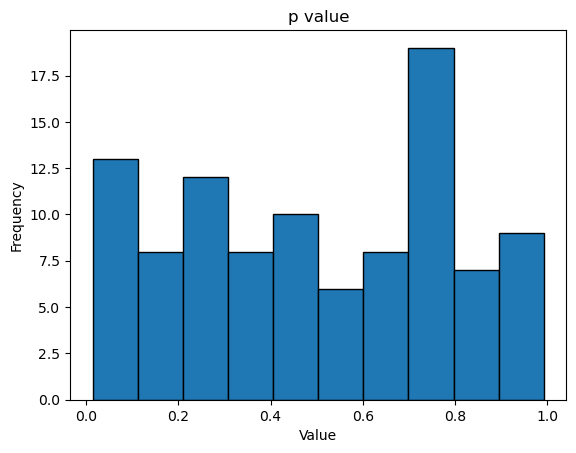

In [10]:
# Creating the histogram
plt.hist(p_vals_class[:100], bins=10, edgecolor='black')

# Adding titles and labels
plt.title('p value')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Showing the plot
plt.show()


In [11]:
p_vals_class[:100]

array([0.71893334, 0.30645001, 0.06233333, 0.25648335, 0.52043337,
       0.3865    , 0.90810001, 0.18245   , 0.74226665, 0.01456667,
       0.7726    , 0.7335667 , 0.06426667, 0.62274998, 0.36883333,
       0.81573331, 0.43928334, 0.7547667 , 0.77421665, 0.58541667,
       0.9454    , 0.23593333, 0.11121666, 0.08236667, 0.15228334,
       0.43099999, 0.87748337, 0.47659999, 0.09451666, 0.46240002,
       0.9925167 , 0.03815   , 0.73811668, 0.81518334, 0.30655   ,
       0.16445   , 0.26539999, 0.79213333, 0.41608334, 0.71081668,
       0.67026669, 0.70598334, 0.01731667, 0.53831667, 0.68494999,
       0.77876669, 0.82541668, 0.51888335, 0.74276668, 0.27478334,
       0.98666668, 0.38798335, 0.36741668, 0.69760001, 0.61449999,
       0.19823334, 0.65934998, 0.01455   , 0.76078331, 0.70573336,
       0.68258333, 0.9152    , 0.74028337, 0.49191669, 0.42506668,
       0.60801667, 0.14701667, 0.0346    , 0.70021665, 0.33075002,
       0.98396665, 0.82446671, 0.90110004, 0.10976667, 0.28170